# 征信预测尝试做

## 金融词汇的某些理解
- 调整金额：

举个例子，在当期你使用信用卡在线支付了1000元飞机票，然而由于原因你退掉了这张飞机票，那么银行会将之前扣掉的1000元在给你打回账户中。这个1000元就是本期调整金额。

- 本期应还款金额=上期还款金额-本期已还款金额+本期账单金额+本期调整金额+循环利息

## 导入常用的包

In [1]:
import time,datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from math import isnan
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

## 导入测试数据

In [2]:
user_info = pd.read_csv('./个人征信/user_info_train.txt',header=None)
user_info.columns = ['user_id','sex','occupation','education','marriage','residence']

In [3]:
bank_detail = pd.read_csv('./个人征信/bank_detail_train.txt',header=None)
bank_detail.columns = ['user_id','timestamp','trade_type','trade_amount','salary_label']

In [4]:
browse_history = pd.read_csv('./个人征信/browse_history_train.txt',header= None)
browse_history.columns = ['user_id','timestamp','behavior_data','behavior_num']

In [5]:
bill_detail = pd.read_csv('./个人征信/bill_detail_train.txt',header = None)
bill_detail.columns = ['user_id',                        # 用户ID
                       'timestamp',                      # 账单时间戳
                       'bank_id',                        # 银行ID
                       'L_BA',                           # 上期账单金额
                       'L_RA',                           # 上期还款金额
                       'credit_card_limit',              # 信用卡额度
                       'C_bill_balance',                 # 本期账单余额
                       'min_C_bill_R',                   # 本期账单最低还款额
                       'number_of_consumption',          # 消费笔数
                       'C_bill_amount',                  # 本期账单金额
                       'adjust_amount',                  # 调整金额
                       'compound_interest',              # 循环利息
                       'available_amount',               # 可用金额
                       'cash_advance_limit',             # 预借现金额度
                       'R_status',                       # 还款状态
                      ]

In [6]:
loan_time = pd.read_csv('./个人征信/loan_time_train.txt',header=None)
loan_time.columns=['user_id','timestamp']

In [7]:
overdue = pd.read_csv('./个人征信/overdue_train.txt',header =  None)
overdue.columns=['user_id','label']

## 观察数据

### user_info

In [8]:
user_info.sex[user_info['sex'] ==0]=np.nan
user_info.head()
user_info.shape
user_info.info()
user_info.dtypes
user_info.isnull().sum()
user_info.isnull().mean()     # 缺失值比例为0.03002
(user_info.user_id.value_counts()>1).sum()       # 这个地方也是为了查看是否存在重复的user_id值

,user_id,sex,occupation,education,marriage,residence
0,3150,1.0,2,4,1,4
1,6965,1.0,2,4,3,2
2,1265,1.0,3,4,3,1
3,6360,1.0,2,4,3,2
4,2583,2.0,2,2,1,1


(55596, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55596 entries, 0 to 55595
Data columns (total 6 columns):
user_id       55596 non-null int64
sex           53927 non-null float64
occupation    55596 non-null int64
education     55596 non-null int64
marriage      55596 non-null int64
residence     55596 non-null int64
dtypes: float64(1), int64(5)
memory usage: 2.5 MB


user_id         int64
sex           float64
occupation      int64
education       int64
marriage        int64
residence       int64
dtype: object

user_id          0
sex           1669
occupation       0
education        0
marriage         0
residence        0
dtype: int64

user_id       0.00000
sex           0.03002
occupation    0.00000
education     0.00000
marriage      0.00000
residence     0.00000
dtype: float64

0

In [9]:
user_info.user_id.unique().shape[0]
# 结果为55596，与user_info这个表的记录数目相同，因此在这个地方，可以看出，没有重复的个人信息。

55596

### bank_detail

In [10]:
#bank_detail.timestamp[bank_detail['timestamp'] ==0]=np.nan
bank_detail.head()
bank_detail.shape # 数据一共有6070197条记录
bank_detail.info()
bank_detail.dtypes
bank_detail.isnull().sum()
bank_detail.isnull().mean()
(bank_detail.user_id.value_counts()>1).sum()  #其中有9292个人具有多条交易记录

,user_id,timestamp,trade_type,trade_amount,salary_label
0,6965,5894316387,0,13.756664,0
1,6965,5894321388,1,13.756664,0
2,6965,5897553564,0,14.449810,0
3,6965,5897563463,1,10.527763,0
4,6965,5897564598,1,13.651303,0


(6070197, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6070197 entries, 0 to 6070196
Data columns (total 5 columns):
user_id         int64
timestamp       int64
trade_type      int64
trade_amount    float64
salary_label    int64
dtypes: float64(1), int64(4)
memory usage: 231.6 MB


user_id           int64
timestamp         int64
trade_type        int64
trade_amount    float64
salary_label      int64
dtype: object

user_id         0
timestamp       0
trade_type      0
trade_amount    0
salary_label    0
dtype: int64

user_id         0.0
timestamp       0.0
trade_type      0.0
trade_amount    0.0
salary_label    0.0
dtype: float64

9292

In [11]:
# 暗示数据的不完整性，只有9294个客户具有交易流水
len(bank_detail.user_id.unique())

9294

In [12]:
# 数据时间为缺失值的记录一共有38773条
bank_detail[bank_detail.timestamp==0].shape[0]

38773

### browse_history

In [13]:
# browse_history.timestamp[browse_history['timestamp'] ==0]=np.nan
browse_history.head()
browse_history.shape
browse_history.info()
browse_history.dtypes
browse_history.isnull().sum()
(browse_history.user_id.value_counts()>1).sum() #其中有47327个人具有多条交易记录

,user_id,timestamp,behavior_data,behavior_num
0,34801,5926003545,173,1
1,34801,5926003545,164,4
2,34801,5926003545,38,7
3,34801,5926003545,45,1
4,34801,5926003545,110,7


(22919547, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22919547 entries, 0 to 22919546
Data columns (total 4 columns):
user_id          int64
timestamp        int64
behavior_data    int64
behavior_num     int64
dtypes: int64(4)
memory usage: 699.4 MB


user_id          int64
timestamp        int64
behavior_data    int64
behavior_num     int64
dtype: object

user_id          0
timestamp        0
behavior_data    0
behavior_num     0
dtype: int64

47327

In [14]:
# 暗示数据的不完整性，只有47330个客户具有数据浏览的记录
len(browse_history.user_id.unique())

47330

In [15]:
# 无数据时间为缺失值的记录
browse_history[browse_history.timestamp==0].shape[0]

0

### bill_detail

In [16]:
# bill_detail.timestamp[bill_detail['timestamp'] ==0]=np.nan
bill_detail.head()
bill_detail.shape   # 总共有2338118条数据
bill_detail.info()
bill_detail.dtypes
bill_detail.isnull().sum()
(bill_detail.user_id.value_counts()>1).sum()

,user_id,timestamp,bank_id,L_BA,L_RA,credit_card_limit,C_bill_balance,min_C_bill_R,number_of_consumption,C_bill_amount,adjust_amount,compound_interest,available_amount,cash_advance_limit,R_status
0,3150,5906744363,6,18.626118,18.661937,20.664418,18.905766,17.847133,1,0.0,0.0,0.0,0.0,19.971271,0
1,3150,5906744401,6,18.905766,18.909954,20.664418,19.113305,17.911506,1,0.0,0.0,0.0,0.0,19.971271,0
2,3150,5906744427,6,19.113305,19.150290,20.664418,19.300194,17.977610,1,0.0,0.0,0.0,0.0,19.971271,0
3,3150,5906744515,6,19.300194,19.300280,21.000890,20.303240,18.477177,1,0.0,0.0,0.0,0.0,20.307743,0
4,3150,5906744562,6,20.303240,20.307744,21.000890,20.357134,18.510985,1,0.0,0.0,0.0,0.0,20.307743,0


(2338118, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2338118 entries, 0 to 2338117
Data columns (total 15 columns):
user_id                  int64
timestamp                int64
bank_id                  int64
L_BA                     float64
L_RA                     float64
credit_card_limit        float64
C_bill_balance           float64
min_C_bill_R             float64
number_of_consumption    int64
C_bill_amount            float64
adjust_amount            float64
compound_interest        float64
available_amount         float64
cash_advance_limit       float64
R_status                 int64
dtypes: float64(10), int64(5)
memory usage: 267.6 MB


user_id                    int64
timestamp                  int64
bank_id                    int64
L_BA                     float64
L_RA                     float64
credit_card_limit        float64
C_bill_balance           float64
min_C_bill_R             float64
number_of_consumption      int64
C_bill_amount            float64
adjust_amount            float64
compound_interest        float64
available_amount         float64
cash_advance_limit       float64
R_status                   int64
dtype: object

user_id                  0
timestamp                0
bank_id                  0
L_BA                     0
L_RA                     0
credit_card_limit        0
C_bill_balance           0
min_C_bill_R             0
number_of_consumption    0
C_bill_amount            0
adjust_amount            0
compound_interest        0
available_amount         0
cash_advance_limit       0
R_status                 0
dtype: int64

49942

In [17]:
# 暗示数据的不完整性，只有53174个客户具有数据浏览的记录
len(bill_detail.user_id.unique()) 
# 数据时间为缺失值的记录总共有427447条
bill_detail[bill_detail.timestamp==0].shape[0]

53174

427447

### loan_time

In [18]:
# loan_time.timestamp[loan_time['timestamp'] ==0]=np.nan
loan_time.head()
loan_time.shape 
loan_time.info()
loan_time.dtypes
loan_time.isnull().sum()
(loan_time.user_id.value_counts()>1).sum()        # 没有任何人有多次的贷款情况

,user_id,timestamp
0,1,5914855887
1,2,5914855887
2,3,5914855887
3,4,5914855887
4,5,5914855887


(55596, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55596 entries, 0 to 55595
Data columns (total 2 columns):
user_id      55596 non-null int64
timestamp    55596 non-null int64
dtypes: int64(2)
memory usage: 868.8 KB


user_id      int64
timestamp    int64
dtype: object

user_id      0
timestamp    0
dtype: int64

0

In [19]:
# 有55596个客户具有数据浏览的记录
len(loan_time.user_id.unique()) 
# 无数据时间为缺失值的记录
loan_time[loan_time.timestamp==0].shape[0]

55596

0

### overdue

In [20]:
overdue.head()
overdue.shape
overdue.info()
overdue.dtypes
overdue.isnull().sum()
(overdue.user_id.value_counts()>1).sum()
overdue['label'].value_counts()  # 样本大小差异较大，因此，需要对于样本做权重调整

,user_id,label
0,1,0
1,2,0
2,3,0
3,4,1
4,5,0


(55596, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55596 entries, 0 to 55595
Data columns (total 2 columns):
user_id    55596 non-null int64
label      55596 non-null int64
dtypes: int64(2)
memory usage: 868.8 KB


user_id    int64
label      int64
dtype: object

user_id    0
label      0
dtype: int64

0

0    48413
1     7183
Name: label, dtype: int64

### 有关每个表中出现的时间的一个处理：

In [21]:
def timestamp_translate(df,out_format="%Y-%m-%d %H:%M:%S"):
    '''
    功能:将时间戳转化为标准的时间格式
    参数：需要变化的Dataframe 以及 输出的日期时间格式
    返回值：改变后的矩阵
    '''
    df1 = df.copy()
    df1.timestamp = df1.timestamp.apply\
    (lambda x:time.strftime(out_format,time.localtime(x)) if x!=0 and not np.isnan(x) else 0)
    return df1

In [22]:
# 银行流水表
b1 = bank_detail.copy()
b1 = b1.sort_values('timestamp')
b1=timestamp_translate(b1)
b=b1.copy()
b1 = b1[b1['timestamp']!=0]
b1['timestamp'].head(5)
b1['timestamp'].tail(5)      

99108      2156-04-25 07:31:27
1243775    2156-04-29 07:31:27
1243774    2156-04-29 07:31:27
1243776    2156-04-29 07:31:27
1243777    2156-05-01 07:31:27
Name: timestamp, dtype: object

3309553    2157-11-18 15:42:19
3309554    2157-11-18 15:45:41
3309555    2157-11-18 15:52:58
4386498    2157-11-18 19:03:56
4386499    2157-11-18 19:42:41
Name: timestamp, dtype: object

In [23]:
# 浏览记录表
c1 = browse_history.copy()
c1 = c1.sort_values('timestamp')
c1=timestamp_translate(c1)
c = c1.copy()
c1 = c1[c1['timestamp']!=0]
c1['timestamp'].head(5)
c1['timestamp'].tail(5)

14622477    2153-12-18 15:27:18
14622667    2153-12-18 15:27:18
14622382    2153-12-18 15:27:18
14622762    2153-12-18 15:27:18
14622572    2153-12-18 15:27:18
Name: timestamp, dtype: object

5746629    2157-12-26 03:55:28
5746268    2157-12-26 03:55:28
5746621    2157-12-26 03:55:28
5746366    2157-12-26 03:55:28
5746038    2157-12-26 03:55:28
Name: timestamp, dtype: object

In [24]:
# 账单表
d1 = bill_detail.copy()
d1 = d1.sort_values('timestamp')
d1=timestamp_translate(d1)
d = d1.copy()
d1 = d1[d1['timestamp']!=0]
d1['timestamp'].head(5)
d1['timestamp'].tail(5)

1817250    2152-02-11 13:35:27
1817251    2152-03-12 14:45:27
218106     2152-03-13 11:51:27
218107     2152-04-13 13:07:27
218108     2152-05-14 02:22:27
Name: timestamp, dtype: object

1556582    2158-08-19 21:20:55
1556583    2158-08-19 21:20:59
1556584    2158-08-19 21:21:06
1556585    2158-08-19 21:21:12
1556586    2158-08-19 21:21:21
Name: timestamp, dtype: object

In [25]:
# 放款时间表
e1 = loan_time.copy()
e1.sort_values('timestamp',inplace = True)
e1=timestamp_translate(e1)
e = e1.copy()
e1 = e1[e1['timestamp']!=0]
e1['timestamp'].head(5)
e1['timestamp'].tail(5)   

0     2157-06-08 07:31:27
81    2157-06-08 07:31:27
80    2157-06-08 07:31:27
79    2157-06-08 07:31:27
78    2157-06-08 07:31:27
Name: timestamp, dtype: object

55438    2157-12-25 07:31:27
55439    2157-12-25 07:31:27
55440    2157-12-25 07:31:27
55442    2157-12-25 07:31:27
55595    2157-12-25 07:31:27
Name: timestamp, dtype: object

- 举例

In [26]:
b[b['user_id']==6965]
c[c['user_id']==6965]
d[d['user_id']==6965]
e[e['user_id']==6965]

,user_id,timestamp,trade_type,trade_amount,salary_label
0,6965,2156-10-13 14:06:27,0,13.756664,0
1,6965,2156-10-13 15:29:48,1,13.756664,0
2,6965,2156-11-20 01:19:24,0,14.449810,0
3,6965,2156-11-20 04:04:23,1,10.527763,0
4,6965,2156-11-20 04:23:18,1,13.651303,0
5,6965,2156-11-20 04:23:18,1,8.235467,0
7,6965,2156-11-21 04:09:23,1,13.063517,0
6,6965,2156-11-21 04:09:23,1,8.235467,0
8,6965,2156-11-23 06:46:11,1,6.288647,0
9,6965,2156-11-23 06:55:45,1,13.063517,0


,user_id,timestamp,behavior_data,behavior_num
18214017,6965,2156-06-26 09:21:29,45,1
18214013,6965,2156-06-26 09:21:29,133,4
18214012,6965,2156-06-26 09:21:29,120,1
18215427,6965,2156-06-26 09:21:29,103,6
18214010,6965,2156-06-26 09:21:29,164,4
18214011,6965,2156-06-26 09:21:29,50,6
18213998,6965,2156-06-26 09:21:29,118,1
18215152,6965,2156-06-26 09:21:29,120,1
18214866,6965,2156-06-26 09:21:29,50,6
18214865,6965,2156-06-26 09:21:29,164,4


,user_id,timestamp,bank_id,L_BA,L_RA,credit_card_limit,C_bill_balance,min_C_bill_R,number_of_consumption,C_bill_amount,adjust_amount,compound_interest,available_amount,cash_advance_limit,R_status
38,6965,0,10,20.027371,19.317344,19.971271,19.983264,16.987546,5,19.194742,0.0,15.728101,0.0,19.278123,0
39,6965,0,10,19.983264,17.915546,19.971271,19.889440,16.893721,2,16.166307,0.0,15.778343,0.0,19.278123,0
40,6965,2158-03-04 07:31:27,13,0.000000,6.849967,19.971271,19.978909,17.499557,18,19.969689,0.0,15.288139,0.0,19.971271,0
41,6965,2158-03-04 08:28:27,13,0.000000,6.849967,19.971271,19.978909,17.499557,18,19.969689,0.0,15.288139,0.0,19.971271,0


,user_id,timestamp
6964,6965,2157-09-20 07:31:27


In [27]:
b[b['user_id']==2583]
c[c['user_id']==2583]
d[d['user_id']==2583]
e[e['user_id']==2583]

,user_id,timestamp,trade_type,trade_amount,salary_label
784,2583,2156-05-28 07:31:27,1,10.240090,0
785,2583,2156-05-28 07:31:27,0,6.404276,0
783,2583,2156-05-28 07:31:27,1,11.083029,0
788,2583,2156-05-29 07:31:27,1,13.849562,0
787,2583,2156-05-29 07:31:27,1,14.855275,0
786,2583,2156-05-29 07:31:27,1,8.589559,0
789,2583,2156-05-30 07:31:27,1,10.760951,0
790,2583,2156-05-31 07:31:27,1,9.844693,0
791,2583,2156-05-31 07:31:27,1,9.151598,0
792,2583,2156-06-01 07:31:27,1,9.141549,0


,user_id,timestamp,behavior_data,behavior_num
13964381,2583,2156-08-13 00:22:22,118,1
13964771,2583,2156-08-13 00:22:22,118,1
13964865,2583,2156-08-13 00:22:22,82,1
13964772,2583,2156-08-13 00:22:22,194,4
13964382,2583,2156-08-13 00:22:22,194,4
13964460,2583,2156-08-13 00:22:22,194,4
13964484,2583,2156-08-13 00:22:22,50,6
13964536,2583,2156-08-13 00:22:22,76,5
13964537,2583,2156-08-13 00:22:22,118,1
13964379,2583,2156-08-13 00:22:22,45,1


,user_id,timestamp,bank_id,L_BA,L_RA,credit_card_limit,C_bill_balance,min_C_bill_R,number_of_consumption,C_bill_amount,adjust_amount,compound_interest,available_amount,cash_advance_limit,R_status
254,2583,0,10,18.106398,18.115932,19.460445,18.262266,17.412786,3,18.267643,0.0,12.386246,0.0,18.767298,0
253,2583,0,10,19.174042,17.610293,19.460445,19.429477,17.686270,2,18.441143,0.0,15.254946,0.0,18.767298,0
252,2583,0,9,20.201313,18.490226,20.664418,20.197880,-18.601660,1,18.471073,0.0,0.000000,0.0,0.000000,0
251,2583,0,10,19.429477,17.686525,19.460445,19.384712,16.386895,1,17.260176,0.0,15.353015,0.0,18.767298,0
250,2583,0,9,20.197880,17.157893,20.664418,20.301999,-18.846263,0,18.349983,0.0,0.000000,0.0,0.000000,0
249,2583,0,9,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.0,0.000000,0.0,0.000000,0
248,2583,0,10,19.384712,19.998886,19.460445,18.576129,15.580405,1,19.642155,0.0,0.000000,0.0,18.767298,0
247,2583,0,13,0.000000,0.000000,21.069883,21.076799,18.208460,2,21.074943,0.0,14.786282,0.0,20.376736,0
246,2583,0,9,20.301999,19.539949,20.664418,20.074127,-17.773226,0,18.966149,0.0,0.000000,0.0,0.000000,0
245,2583,0,10,19.198729,19.248076,19.460445,19.174042,17.607958,2,19.221523,0.0,13.436459,0.0,18.767298,0


,user_id,timestamp
2582,2583,2157-07-06 07:31:27


In [28]:
b[b['user_id']==590]
c[c['user_id']==590]
d[d['user_id']==590]
e[e['user_id']==590]

,user_id,timestamp,trade_type,trade_amount,salary_label
2888,590,0,0,17.933863,0
2889,590,0,0,17.305906,0
2890,590,0,0,14.847018,0
2891,590,0,0,18.733023,0
2892,590,0,0,17.916375,0
2893,590,0,0,16.224036,0
2894,590,0,0,18.554322,0
2887,590,0,0,16.777417,0
2895,590,0,0,17.622419,0
2897,590,0,0,15.339732,0


,user_id,timestamp,behavior_data,behavior_num
22362698,590,2156-08-15 12:50:09,173,1
22362713,590,2156-08-15 12:50:09,82,1
22362712,590,2156-08-15 12:50:09,190,10
22362711,590,2156-08-15 12:50:09,139,4
22362710,590,2156-08-15 12:50:09,45,1
22362686,590,2156-08-15 12:50:09,164,4
22362709,590,2156-08-15 12:50:09,118,1
22362708,590,2156-08-15 12:50:09,173,1
22362707,590,2156-08-15 12:50:09,50,6
22362706,590,2156-08-15 12:50:09,164,4


,user_id,timestamp,bank_id,L_BA,L_RA,credit_card_limit,C_bill_balance,min_C_bill_R,number_of_consumption,C_bill_amount,adjust_amount,compound_interest,available_amount,cash_advance_limit,R_status
1057,590,0,6,20.441223,0.000000,20.441274,20.460804,18.878392,2,0.0,0.0,0.0,0.0,19.748127,0
1056,590,0,6,20.441270,0.000000,20.441274,20.465986,19.054320,7,0.0,0.0,0.0,0.0,19.748127,0
1055,590,0,6,20.460804,20.461322,20.441274,20.441270,18.140949,1,0.0,0.0,0.0,0.0,19.748127,0
1054,590,0,6,20.440051,20.441899,20.441274,20.441345,18.330466,2,0.0,0.0,0.0,0.0,0.000000,0
1053,590,0,6,20.441345,20.479413,20.441274,20.438658,18.443726,3,0.0,0.0,0.0,0.0,0.000000,0
1052,590,0,6,20.423645,20.498759,20.441274,20.441238,18.139526,5,0.0,0.0,0.0,0.0,0.000000,0
1051,590,0,6,20.438658,20.460464,20.441274,20.423645,18.321198,2,0.0,0.0,0.0,0.0,0.000000,0
1058,590,2156-11-11 21:35:27,6,20.440051,20.441899,20.441274,20.441345,18.330466,2,0.0,0.0,0.0,0.0,19.748127,0
1059,590,2156-12-11 09:26:27,6,20.441345,20.479413,20.441274,20.438658,18.443726,3,0.0,0.0,0.0,0.0,19.748127,0
1060,590,2157-01-11 22:12:27,6,20.438658,20.460464,20.441274,20.423645,18.321198,2,0.0,0.0,0.0,0.0,19.748127,0


,user_id,timestamp
589,590,2157-06-14 07:31:27


## 数据预处理

In [29]:
# 构造哑变量来处理多字符变量
def get_df_dummies(df,feature_list):
    '''
    功能:将函数的特征列构造成为哑变量
    paramas: Datafram & 需要修改的列名
    返回值:构建好的哑变量列表
    '''
    df1 = df.copy()
    for var in feature_list:
        temp= pd.get_dummies(df1[var], prefix=var, prefix_sep='_')
        del df1[var]
        df1 = pd.concat([df1,temp], axis=1)
    return df1

### user_info

In [30]:
user_info.head()

,user_id,sex,occupation,education,marriage,residence
0,3150,1.0,2,4,1,4
1,6965,1.0,2,4,3,2
2,1265,1.0,3,4,3,1
3,6360,1.0,2,4,3,2
4,2583,2.0,2,2,1,1


In [31]:
# 对于性别列的处理：
# 考虑到性别对于征信评估有较大的关联性，因此，对于性别进行了处理：
# 1.删除掉了具有性别缺失值的记录；2.将原本性别为2的记录改为性别为0
user_info1 = user_info.dropna()
user_info1['sex'][user_info1['sex']==2]=0
user_info1.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\Anaconda3\lib\site-packages\pandas\core\generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
D:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,user_id,sex,occupation,education,marriage,residence
0,3150,1.0,2,4,1,4
1,6965,1.0,2,4,3,2
2,1265,1.0,3,4,3,1
3,6360,1.0,2,4,3,2
4,2583,0.0,2,2,1,1


In [32]:
#处理剩下的几个多字符变量
feature_list = list(user_info1)[2:6]
user_info1 = get_df_dummies(user_info1,feature_list)
user_info1.head()

,user_id,sex,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,education_0,education_1,education_2,...,marriage_1,marriage_2,marriage_3,marriage_4,marriage_5,residence_0,residence_1,residence_2,residence_3,residence_4
0,3150,1.0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,6965,1.0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1265,1.0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,6360,1.0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,2583,0.0,0,0,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


### bank_detail

In [33]:
bank_detail.head()

,user_id,timestamp,trade_type,trade_amount,salary_label
0,6965,5894316387,0,13.756664,0
1,6965,5894321388,1,13.756664,0
2,6965,5897553564,0,14.449810,0
3,6965,5897563463,1,10.527763,0
4,6965,5897564598,1,13.651303,0


In [34]:
# 因为要对银行的交易流水进行分析，通过时间维度来进行聚合，因此会对时间戳为0的数据进行处理
bank_detail.timestamp[bank_detail['timestamp'] ==0]=np.nan
bank_detail.isnull().mean() # 发现空值比例仅仅0.006387，因此，删除了为空的记录
bank_detail1 = bank_detail.dropna()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


user_id         0.000000
timestamp       0.006387
trade_type      0.000000
trade_amount    0.000000
salary_label    0.000000
dtype: float64

In [35]:
#对于时间戳进行时间转化
bank_detail1= timestamp_translate(bank_detail1,'%Y-%m')

In [36]:
# 将原来的交易行为和交易金额更换为两个新的特征变量，分别记录收入和支出，然后删除原来的交易金额以及交易行为
bank_detail1['income']=bank_detail1['expend']=0
bank_detail1['income'] = bank_detail1['trade_amount']*(1-bank_detail1['trade_type'])
bank_detail1['expend'] = bank_detail1['trade_amount']*(bank_detail1['trade_type'])

bank_detail1 = bank_detail1.drop(['trade_type','trade_amount'],axis=1)

In [37]:
# 根据用户ID和时间戳对于数据进行聚合
bank_detail2 = bank_detail1.groupby(by=['user_id','timestamp']).\
agg({'user_id':'count','income':'sum','expend':'sum','salary_label':'sum'})

In [38]:
# 生成新的特征变量计算每月的合计交易情况
bank_detail2['trade_amount']=bank_detail2['income']-bank_detail2['expend']

In [39]:
# 生成新的特征变量，判别每月的交易正负情况，用于之后计数
bank_detail2['trade_labels_1']=bank_detail2['trade_amount'].apply(lambda x:1 if x>0 else 0)
bank_detail2['trade_labels_-1']=bank_detail2['trade_amount'].apply(lambda x:1 if x<0 else 0)
bank_detail2.columns = ['comsumption_freq','income','expend','salary_label','trade_amount','trade_labels_1','trade_labels_-1']

In [40]:
#再次根据用户ID对于数据进行聚合
bank_detail2 = bank_detail2.groupby('user_id').agg({'comsumption_freq':'sum',
                                                    'income':'sum',
                                                    'expend':'sum',
                                                    'trade_amount':['sum','count'],
                                                    'salary_label':'mean',
                                                    'trade_labels_1':'sum',
                                                    'trade_labels_-1':'sum'})
bank_detail2.columns = ['comsumption_freq',
                        'income', 
                        'expend', 
                        'trade_amount',
                        'month_',
                        'salary_label',
                        'trade_labels_1', 
                        'trade_labels_-1']

In [41]:
# 用用户总量以及流水月份还有消费频数来进行计算月均和单笔消费的情况
bank_detail2['monthly_mean'] = bank_detail2['trade_amount']/bank_detail2['month_']
bank_detail2['each_mean'] = bank_detail2['trade_amount']/bank_detail2['comsumption_freq']

bank_detail2 = bank_detail2.drop(['comsumption_freq','month_','trade_amount'],axis=1)

In [42]:
# 重置索引
bank_detail2 = bank_detail2.reset_index()
bank_detail2.head()

,user_id,income,expend,salary_label,trade_labels_1,trade_labels_-1,monthly_mean,each_mean
0,1,480.692762,676.025269,0.0,2,7,-16.277709,-2.271308
1,3,1715.933526,4985.957607,0.0,0,13,-251.540314,-5.061957
2,4,928.506655,2129.425722,0.0,0,13,-92.378390,-4.335448
3,9,152.871054,141.544665,0.0,1,3,2.831597,0.514836
4,10,1793.642133,2250.292530,0.0,2,10,-35.126954,-1.409415


### browse_history

In [43]:
browse_history.head()

,user_id,timestamp,behavior_data,behavior_num
0,34801,5926003545,173,1
1,34801,5926003545,164,4
2,34801,5926003545,38,7
3,34801,5926003545,45,1
4,34801,5926003545,110,7


In [44]:
# PCA 似乎无法使用，因为涉及到了离散型变量内容
# from sklearn.decomposition import PCA
# pca = PCA(n_components=1)
# pca = pca.fit_transform(browse_history[['behavior_data','behavior_num']])
# browse_history['behavior_pca']=pca
# browse_history.drop(['timestamp','behavior_data','behavior_num'],axis=1)

In [45]:
# 希望能够构造一个数据透析表，如果能够直接将行为
# browse_history2 = browse_history.copy()
# browse_history2['time']=1
# browse_history3 = browse_history2.pivot_table(index='user_id',
#                                               columns=['behavior_num','behavior_data'],
#                                               values='timestamp',
#                                               aggfunc='sum')

In [46]:
# 对于数据浏览的情况进行聚合，对于每一个人，根据用户id和行为编号来进行聚合，并且求行为频数
browse_history1 = browse_history.groupby(by =['user_id','behavior_num']).count()
browse_history1.head()

timestamp  behavior_data
user_id behavior_num                          
2       1                   540            540
        3                    90             90
        4                   150            150
        5                   105            105
        6                   135            135

In [47]:
browse_history1=browse_history1.pivot_table(index='user_id',columns='behavior_num',values='timestamp' )
browse_history1.head()

behavior_num,1,2,3,4,5,6,7,8,9,10,11
user_id,,,,,,,,,,,
2,540.0,NaN,90.0,150.0,105.0,135.0,105.0,105.0,NaN,75.0,NaN
3,174.0,NaN,NaN,48.0,30.0,24.0,42.0,NaN,NaN,24.0,NaN
4,164.0,NaN,4.0,64.0,36.0,32.0,36.0,4.0,NaN,24.0,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN
7,462.0,NaN,NaN,140.0,98.0,98.0,112.0,14.0,NaN,84.0,NaN


###  bill_detail

In [48]:
bill_detail.head()

,user_id,timestamp,bank_id,L_BA,L_RA,credit_card_limit,C_bill_balance,min_C_bill_R,number_of_consumption,C_bill_amount,adjust_amount,compound_interest,available_amount,cash_advance_limit,R_status
0,3150,5906744363,6,18.626118,18.661937,20.664418,18.905766,17.847133,1,0.0,0.0,0.0,0.0,19.971271,0
1,3150,5906744401,6,18.905766,18.909954,20.664418,19.113305,17.911506,1,0.0,0.0,0.0,0.0,19.971271,0
2,3150,5906744427,6,19.113305,19.150290,20.664418,19.300194,17.977610,1,0.0,0.0,0.0,0.0,19.971271,0
3,3150,5906744515,6,19.300194,19.300280,21.000890,20.303240,18.477177,1,0.0,0.0,0.0,0.0,20.307743,0
4,3150,5906744562,6,20.303240,20.307744,21.000890,20.357134,18.510985,1,0.0,0.0,0.0,0.0,20.307743,0


In [49]:
# 基于之前的观察，时间戳并没有任何的作用，并且银行id，也没有作用。
# 最低还款额，可用金额，预借现金额度与其他的特征在经济意义上都都有一定的相关性。因此。对以上特征进行删除。
bill_detail1 = bill_detail.drop(['timestamp',
                                 'bank_id','min_C_bill_R',
                                 'available_amount','cash_advance_limit'],axis=1)
bill_detail2 = bill_detail1.copy()
bill_detail2.head()

,user_id,L_BA,L_RA,credit_card_limit,C_bill_balance,number_of_consumption,C_bill_amount,adjust_amount,compound_interest,R_status
0,3150,18.626118,18.661937,20.664418,18.905766,1,0.0,0.0,0.0,0
1,3150,18.905766,18.909954,20.664418,19.113305,1,0.0,0.0,0.0,0
2,3150,19.113305,19.150290,20.664418,19.300194,1,0.0,0.0,0.0,0
3,3150,19.300194,19.300280,21.000890,20.303240,1,0.0,0.0,0.0,0
4,3150,20.303240,20.307744,21.000890,20.357134,1,0.0,0.0,0.0,0


In [50]:
#因为考虑到上期到下的一个结转金额经常会作为一个评判标准，因此新生成一个到下期的结转金额
bill_detail2['L_F'] = bill_detail2['L_BA']-bill_detail2['L_RA']
bill_detail2 = bill_detail2.drop(['L_BA','L_RA'],axis=1)
bill_detail2.head()

,user_id,credit_card_limit,C_bill_balance,number_of_consumption,C_bill_amount,adjust_amount,compound_interest,R_status,L_F
0,3150,20.664418,18.905766,1,0.0,0.0,0.0,0,-0.035819
1,3150,20.664418,19.113305,1,0.0,0.0,0.0,0,-0.004188
2,3150,20.664418,19.300194,1,0.0,0.0,0.0,0,-0.036985
3,3150,21.000890,20.303240,1,0.0,0.0,0.0,0,-0.000086
4,3150,21.000890,20.357134,1,0.0,0.0,0.0,0,-0.004504


In [51]:
# 新生成一列特征，表示当期已经还款的金额
# 本期已还款金额 = 上期结转金额 + 本期账单金额 + 本期调整金额 + 循环利息 - 账单余额
bill_detail2['C_ped']=bill_detail2['L_F']+bill_detail2['C_bill_amount']+bill_detail2['adjust_amount']\
                     +bill_detail2['compound_interest']-bill_detail2['C_bill_balance']

bill_detail2 = bill_detail2.drop(['adjust_amount','compound_interest'],axis=1)

bill_detail2.head(5)

,user_id,credit_card_limit,C_bill_balance,number_of_consumption,C_bill_amount,R_status,L_F,C_ped
0,3150,20.664418,18.905766,1,0.0,0,-0.035819,-18.941585
1,3150,20.664418,19.113305,1,0.0,0,-0.004188,-19.117493
2,3150,20.664418,19.300194,1,0.0,0,-0.036985,-19.337179
3,3150,21.000890,20.303240,1,0.0,0,-0.000086,-20.303326
4,3150,21.000890,20.357134,1,0.0,0,-0.004504,-20.361638


In [52]:
# 新生成两列数据分别记录是否拖欠了上月的账单
bill_detail2['L_F_1'] = bill_detail2['L_F'].apply(lambda x:1 if x>0 else 0)
bill_detail2['L_F_-1'] = bill_detail2['L_F'].apply(lambda x:1 if x<0 else 0)

Text(0.5, 1.0, 'credit_card_limit')

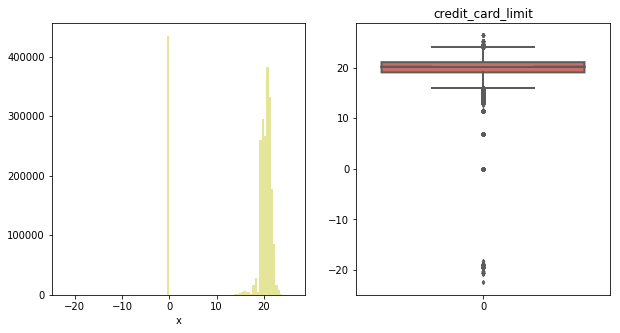

Text(0.5, 1.0, 'C_bill_balance')

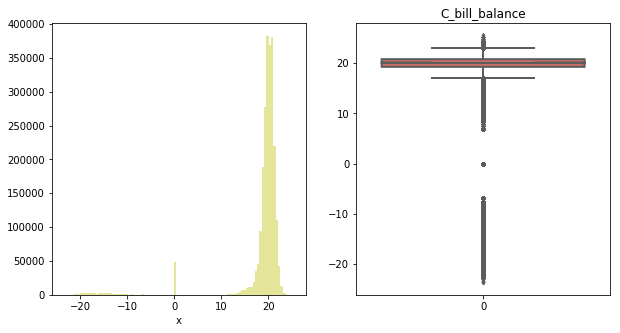

Text(0.5, 1.0, 'number_of_consumption')

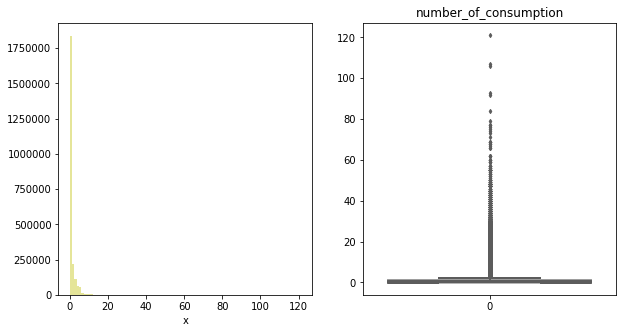

Text(0.5, 1.0, 'C_bill_amount')

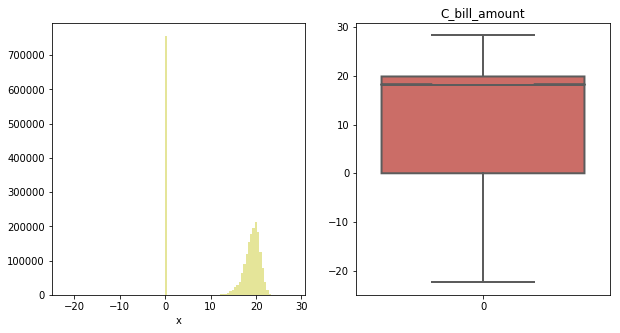

Text(0.5, 1.0, 'R_status')

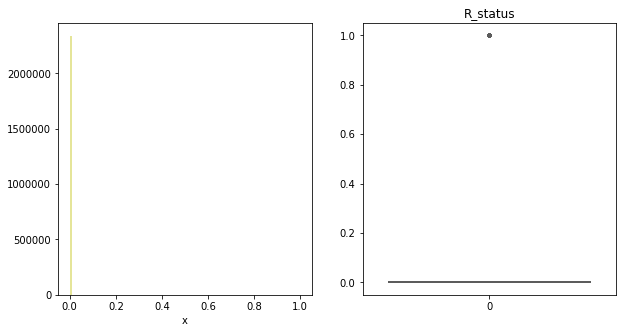

Text(0.5, 1.0, 'L_F')

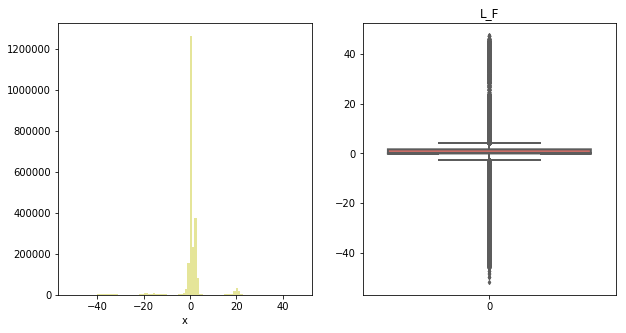

Text(0.5, 1.0, 'C_ped')

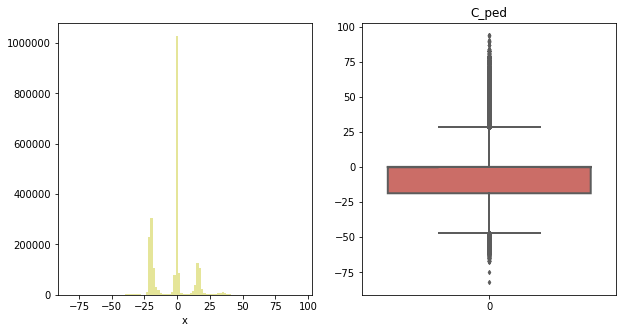

Text(0.5, 1.0, 'L_F_1')

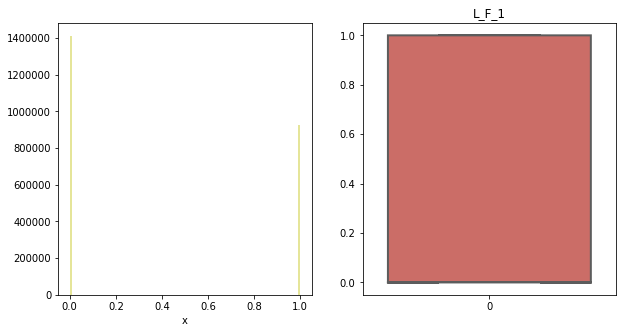

Text(0.5, 1.0, 'L_F_-1')

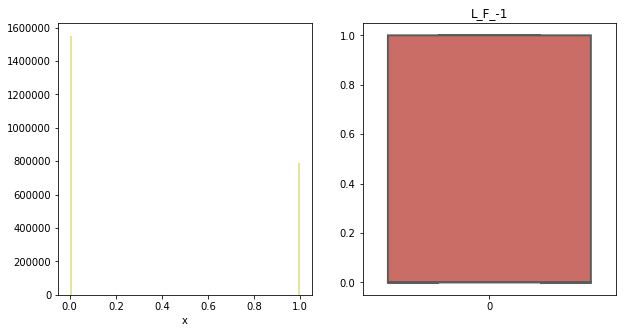

In [53]:
# 画出直方图和箱线图，再次观察数据是否有较大的异常值
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

for i in bill_detail2.columns[1:]:
    fig,axes = plt.subplots(1,2,figsize = (10,5))
    sns.distplot(bill_detail2[i],bins = 100,hist = True,kde = False,norm_hist=False,
                rug = False,vertical = False,
                color = 'y',axlabel = 'x',
                ax=axes[0])
    sns.boxplot(data=bill_detail2[i],
            linewidth = 2,   # 线宽
            fliersize = 3,   # 异常点大小
            palette = 'hls', # 设置调色板
            whis = 1.5,      # 设置IQR 
            notch = True,    # 设置是否以中值做凹槽  # 筛选类别
            ax=axes[1])
    plt.title(i)
    plt.show()

In [54]:
# 有关信用卡额度的异常值
bill_detail2[bill_detail2['credit_card_limit']<-10].shape
# 存在信用卡额度为负数的情况：
# “信用卡的余额为负数是个正常现象，它表示你之前多还了银行的钱，这部分钱款叫做信用卡的溢缴款”

(97, 10)

In [55]:
# 有关消费频数
bill_detail2[bill_detail2['number_of_consumption']>80].shape
# 由于存在少量的异常，直接删除该数据
bill_detail2 = bill_detail2[bill_detail2['number_of_consumption']<= 80]

(6, 10)

In [56]:
# 对于处理的数据进行聚合
bill_detail3 = bill_detail2.groupby('user_id').agg({'credit_card_limit':'mean',
                                         'C_bill_balance':'mean',
                                         'number_of_consumption':'sum',
                                         'C_bill_amount':['sum','mean'],
                                         'R_status':'mean',
                                         'L_F':'mean',
                                         'C_ped':'mean',
                                         'L_F_1':'mean',
                                         'L_F_-1':'mean'}).reset_index()
bill_detail3

user_id credit_card_limit C_bill_balance number_of_consumption  \
                           mean           mean                   sum   
0           2         18.638974      19.872065                    58   
1           3         18.361833      18.348270                     4   
2           4         16.055204      18.847398                     2   
3           5         20.664418      20.636046                     0   
4           6         20.567794      19.176074                   122   
5           7         19.845797       5.357260                   254   
6           8         21.069883      21.068260                     0   
7           9         18.561063      17.464193                     6   
8          10         19.674681      15.875485                   117   
9          11         19.764840      17.647085                    77   
10         12         14.453948      13.355723                   117   
11         13         20.680681      20.669048                    24   
12         14         13.876785      18.690660                     6   
13         15         19.112904      14.368109                     0   
14         16         21.763030      12.225690                     6   
15         17         16.043846      17.925864                   182   
16         18         21.580708      21.369354                     0   
17         19         20.736390      20.226807                    85   
18         20         21.341329      20.665872                    33   
19         21         20.493587      20.282348                    19   
20         22         19.460445      18.751662                     2   
21         23          0.000000      -1.511949                     8   
22         24         19.596470       7.068794                  3162   
23         25         19.460445      19.198266                     0   
24         26         19.971271      19.712874                     0   
25         27         20.664418      20.393683                    77   
26         28         20.461240      18.895108                     8   
27         29         19.054980      19.015423                     0   
28         30         20.851835      20.197184                    19   
29         32         19.460445      19.502752                    11   
...       ...               ...            ...                   ...   
53144   55564         15.366951      19.528221                     8   
53145   55565         13.042815      17.540816                     5   
53146   55566         16.335427      19.395062                   112   
53147   55567          0.000000      -3.878375                     3   
53148   55568         22.369166      20.474945                     0   
53149   55569         12.716294      14.324734                    44   
53150   55570         16.531534      19.480829                    15   
53151   55571          7.503762      18.813057                     0   
53152   55572         17.419076      19.747938                    16   
53153   55573         13.993720      20.251957                    12   
53154   55574         16.388495      20.285235                    43   
53155   55575         20.153592      20.013487                     0   
53156   55576         13.314181      18.900893                     0   
53157   55577         20.664418     -11.083029                     0   
53158   55578         18.613966      17.262203                     0   
53159   55579         20.144558      19.709049                     0   
53160   55580         21.198545      21.219826                     1   
53161   55581         19.748127      19.581168                     4   
53162   55582         21.763030      21.189886                     0   
53163   55584         19.860552       8.703125                     3   
53164   55585         22.318345      20.897816                     0   
53165   55588          9.985635      20.330063                   111   
53166   55589         10.334097      20.091440

In [57]:
bill_detail3.columns= ['user_id',
                       'credit_card_limit',
                       'C_bill_balance',
                        'number_of_consumption',
                        'C_bill_amount_sum',
                        'C_bill_amount_mean_period',
                        'R_status',
                        'L_F',
                        'C_ped',
                        'L_F_1',
                        'L_F_-1']

Text(0.5, 1.0, 'credit_card_limit')

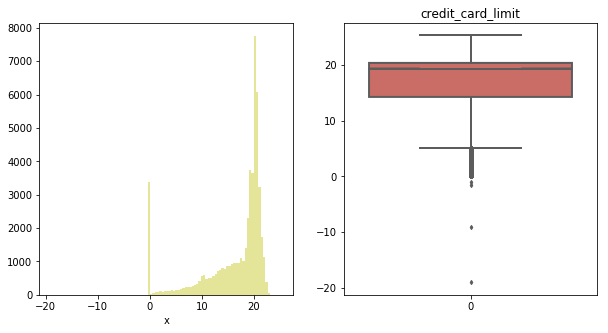

Text(0.5, 1.0, 'C_bill_balance')

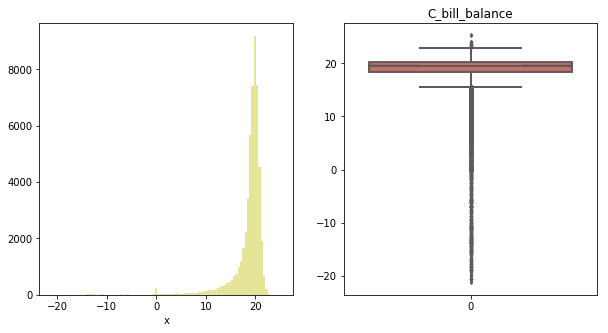

Text(0.5, 1.0, 'number_of_consumption')

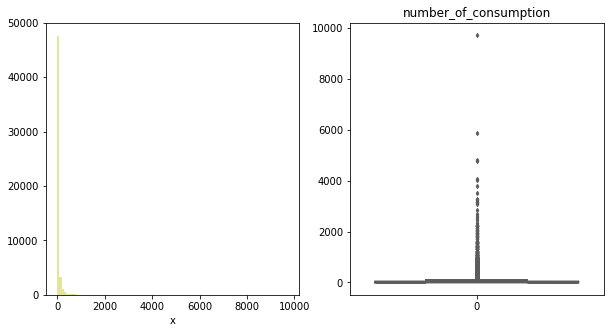

Text(0.5, 1.0, 'C_bill_amount_sum')

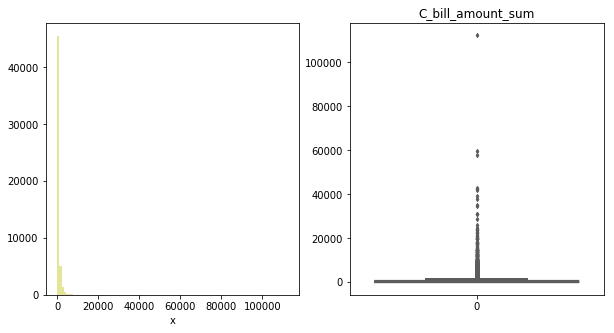

Text(0.5, 1.0, 'C_bill_amount_mean_period')

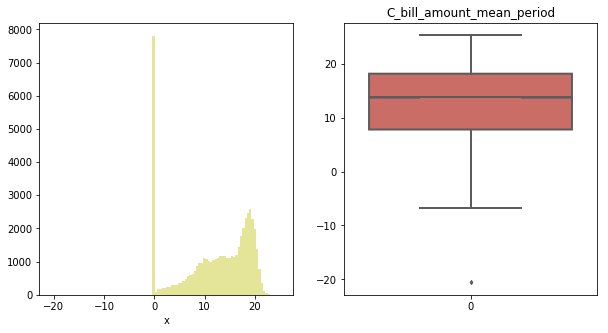

Text(0.5, 1.0, 'R_status')

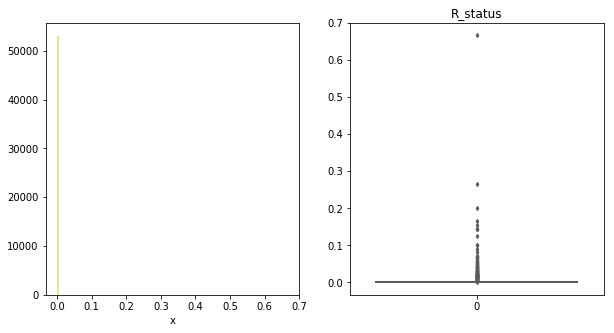

Text(0.5, 1.0, 'L_F')

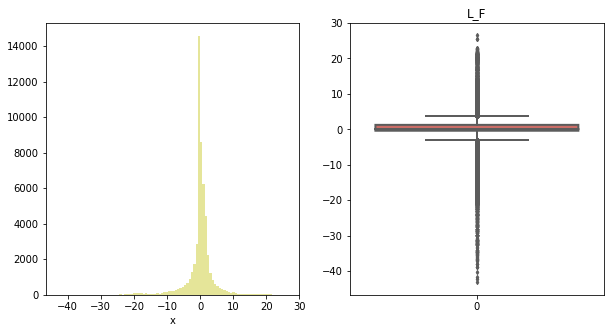

Text(0.5, 1.0, 'C_ped')

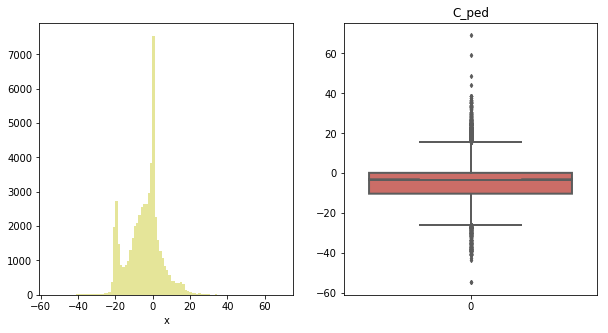

Text(0.5, 1.0, 'L_F_1')

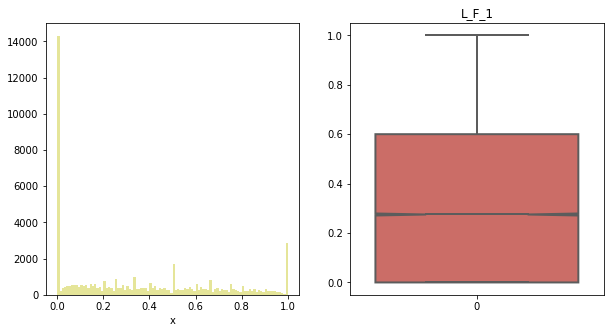

Text(0.5, 1.0, 'L_F_-1')

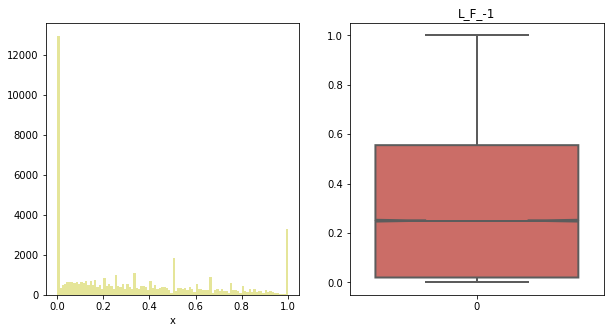

In [58]:
# 再次画出直方图和箱线图，观察数据是否有较大的异常值
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

for i in bill_detail3.columns[1:]:
    fig,axes = plt.subplots(1,2,figsize = (10,5))
    sns.distplot(bill_detail3[i],bins = 100,hist = True,kde = False,norm_hist=False,
                rug = False,vertical = False,
                color = 'y',axlabel = 'x',
                ax=axes[0])
    sns.boxplot(data=bill_detail3[i],
            linewidth = 2,   # 线宽
            fliersize = 3,   # 异常点大小
            palette = 'hls', # 设置调色板
            whis = 1.5,      # 设置IQR 
            notch = True,    # 设置是否以中值做凹槽  # 筛选类别
            ax=axes[1])
    plt.title(i)
    plt.show()

In [59]:
# 这次存在少量的信用额度为负数的情况，对此删除
bill_detail3[bill_detail3['credit_card_limit']<-5].shape
bill_detail3 = bill_detail3[bill_detail3['credit_card_limit']>-5]

(2, 11)

In [60]:
# 保留交易笔数小于5000的数据
bill_detail3[bill_detail3['number_of_consumption']>5000].shape
bill_detail3 = bill_detail3[bill_detail3['number_of_consumption']<=5000]

(2, 11)

In [61]:
# 保留账单金额小于50000的数据
bill_detail3[bill_detail3['C_bill_amount_sum']>50000].shape
bill_detail3 = bill_detail3[bill_detail3['C_bill_amount_sum']<=50000]

(3, 11)

In [62]:
# 保留交易期均值大于-10的数据
bill_detail3[bill_detail3['C_bill_amount_mean_period']<-10].shape
bill_detail3 = bill_detail3[bill_detail3['C_bill_amount_mean_period']>-10]

(1, 11)

In [63]:
df_all = pd.merge(user_info1,browse_history1,how='left',on='user_id')
df_all = pd.merge(df_all,bill_detail3,how='left',on='user_id')
df_all = pd.merge(df_all,bank_detail2,how='left',on='user_id')
df_all = pd.merge(df_all,overdue,how='left',on='user_id')

In [64]:
df_all.head()

,user_id,sex,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,education_0,education_1,education_2,...,L_F_1,L_F_-1,income,expend,salary_label,trade_labels_1,trade_labels_-1,monthly_mean,each_mean,label
0,3150,1.0,0,0,1,0,0,0,0,0,...,0.157895,0.394737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6965,1.0,0,0,1,0,0,0,0,0,...,0.500000,0.500000,972.850228,3234.531975,0.0,0.0,11.0,-188.473479,-6.213411,0
2,1265,1.0,0,0,0,1,0,0,0,0,...,0.629630,0.370370,1708.206195,3662.457063,0.0,0.0,13.0,-150.326990,-4.664083,0
3,6360,1.0,0,0,1,0,0,0,0,0,...,0.687943,0.042553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2583,0.0,0,0,1,0,0,0,0,1,...,0.500000,0.375000,2736.475318,7064.310678,0.0,0.0,13.0,-332.910412,-5.207985,0


In [65]:
df_all.isnull().sum()

user_id                          0
sex                              0
occupation_0                     0
occupation_1                     0
occupation_2                     0
occupation_3                     0
occupation_4                     0
education_0                      0
education_1                      0
education_2                      0
education_3                      0
education_4                      0
marriage_0                       0
marriage_1                       0
marriage_2                       0
marriage_3                       0
marriage_4                       0
marriage_5                       0
residence_0                      0
residence_1                      0
residence_2                      0
residence_3                      0
residence_4                      0
1                             8021
2                            53878
3                            46021
4                            10749
5                            18772
6                   

In [66]:
# 用0值来对df_all中的数据行为进行填充，表示该客户没有进行过数据行为
df_all.iloc[:,23:34] = df_all.iloc[:,23:34].fillna(0)
# 用0值来对df_all中的信用卡账单数据进行填充，表示该客户没有使用过信用卡
df_all.iloc[:,34:44] = df_all.iloc[:,34:44].fillna(0)

In [67]:
df_all.head()

,user_id,sex,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,education_0,education_1,education_2,...,L_F_1,L_F_-1,income,expend,salary_label,trade_labels_1,trade_labels_-1,monthly_mean,each_mean,label
0,3150,1.0,0,0,1,0,0,0,0,0,...,0.157895,0.394737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6965,1.0,0,0,1,0,0,0,0,0,...,0.500000,0.500000,972.850228,3234.531975,0.0,0.0,11.0,-188.473479,-6.213411,0
2,1265,1.0,0,0,0,1,0,0,0,0,...,0.629630,0.370370,1708.206195,3662.457063,0.0,0.0,13.0,-150.326990,-4.664083,0
3,6360,1.0,0,0,1,0,0,0,0,0,...,0.687943,0.042553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2583,0.0,0,0,1,0,0,0,0,1,...,0.500000,0.375000,2736.475318,7064.310678,0.0,0.0,13.0,-332.910412,-5.207985,0


In [68]:
df_all.shape

(53927, 52)

### 使用随机森林来填补银行账单流水的缺失值

In [70]:
import rfr_fillna   
# 导入自写函数，用于填补缺失值，并且返回两次归一化的填补模型以及随机森林的填补模型，用于测试集模型共用

In [71]:
df_all,model,MinMax_1st,MinMax_2nd = rfr_fillna.rfr_fillna(df_all)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
  0%|                                                    | 0/7 [00:00<?, ?it/s]D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
 14%|██████▎                                     | 1/7 [01:00<06:05, 60.84s/it]D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
 29%|████████████▌                               | 2/7 [01:15<03:55, 47.05s/it]D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will cha

## 模型建立以及筛选

In [72]:
from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV as GSC
import seaborn as sns
import scikitplot as skplt
import con_matrix
from tqdm import tqdm
import time

In [73]:
X = df_all.iloc[:,1:-1]
y = df_all.iloc[:,-1]

In [74]:
# 划分训练集和用于检测泛化的样本集
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3)

### 随机森林


100%|████████████████████████████████████████████| 4/4 [05:01<00:00, 75.64s/it]

wrfc 2 0.8782981906199109


wrfc 0.8806477532603992


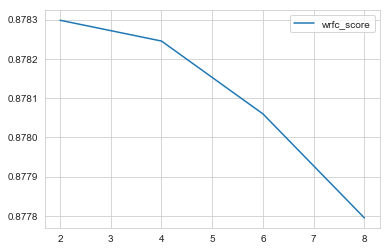

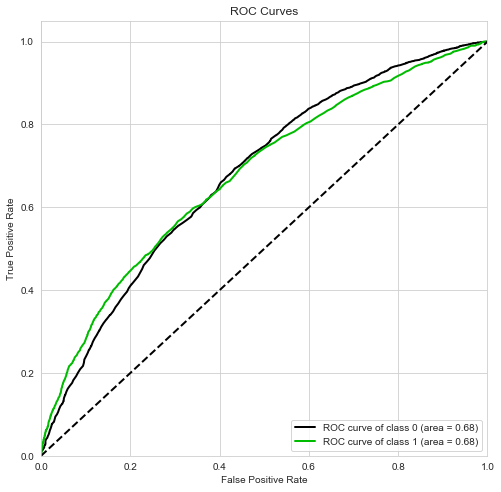

accuracy: 0.8786080721923482
precision: 0.43523316062176165
confusion matrix [[   84  1855]
 [  109 14131]]


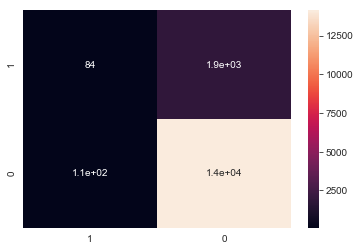

In [123]:
from sklearn.ensemble import RandomForestClassifier as RFC

rfc_score = []
wrfc_score = []
krange = range(2,10,2)
for i in tqdm(krange):
    wrfc = RFC(n_estimators=1000,criterion='entropy',min_samples_split=i,n_jobs=-1,class_weight='balanced')
    score2 = cvs(wrfc,X_train,Y_train,cv=3,n_jobs=-1).mean()
    wrfc_score.append(score2)

print('wrfc',list(krange)[np.argmax(wrfc_score)],np.max(wrfc_score))
sns.set_style('whitegrid')
plt.plot((krange),wrfc_score,label ='wrfc_score');
plt.legend()

wrfc = RFC(n_estimators=1000,criterion='entropy',min_samples_split=list(krange)[np.argmax(wrfc_score)],n_jobs=-1,
           class_weight='balanced')
wrfc = wrfc.fit(X_train,Y_train)
print('wrfc',wrfc.score(X_test,Y_test))


y_probas_wrfc = wrfc.predict_proba(X_test)  
skplt.metrics.plot_roc(Y_test,y_probas_wrfc,plot_macro=False,plot_micro=False,figsize=[8,8]);
plt.show()

y_hat = abt.predict(X_test)
con_matrix.con_matrix(Y_test,y_hat);
plt.show()

In [84]:
# 网格搜索版本的随机森林 加了权重
param_grid = { 
#                 'max_depth':np.arange(44,45),
                'min_samples_split':np.arange(6,20),
                'min_samples_leaf':np.arange(4, 20, 1)}
wrfc = RFC(n_estimators=300,criterion='entropy',class_weight='balanced',n_jobs=-1)
GS = GSC(wrfc,param_grid,cv=3)
GS  = GS.fit(X_train,Y_train)
GS.best_params_
GS.best_score_

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'min_samples_leaf': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

{'min_samples_leaf': 4, 'min_samples_split': 6}

0.8773180036028398

### adaboost


100%|██████████████████████████████████████████| 10/10 [04:04<00:00, 23.06s/it]


100%|██████████████████████████████████████████| 10/10 [04:35<00:00, 27.44s/it]


100%|██████████████████████████████████████████| 10/10 [05:25<00:00, 32.42s/it]


100%|██████████████████████████████████████████| 10/10 [06:15<00:00, 37.57s/it]


100%|██████████████████████████████████████████| 10/10 [07:07<00:00, 42.73s/it]

[0.8787485399917051, 250, 0.9000000000000001]


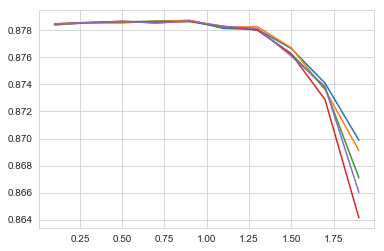

In [120]:
# adaboostclassifier  唐钰清
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

maxscore = [0,0,0]
for i in np.arange(200,401,50):
    score = []
    krange = np.arange(0.1,2.1,0.2)
    for j in tqdm(krange):
        abt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, min_samples_split=20
                                                    , min_samples_leaf=5),algorithm="SAMME"
                                                    , n_estimators=i, learning_rate=j)
        score_each = cvs(abt,X_train,Y_train,cv=3,n_jobs=-1).mean()
        score.append(score_each)
        if score_each>maxscore[0]:
            maxscore = [score_each,i,j]
    plt.plot(krange,score)
print(maxscore)

In [121]:
maxscore

[0.8787485399917051, 250, 0.9000000000000001]

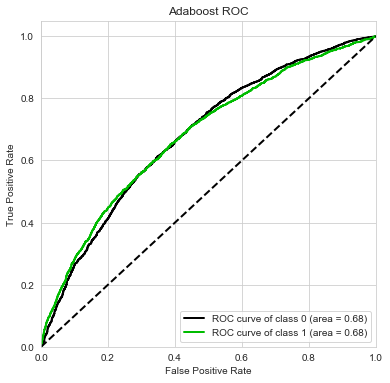

accuracy: 0.8786080721923482
precision: 0.43523316062176165
confusion matrix [[   84  1855]
 [  109 14131]]


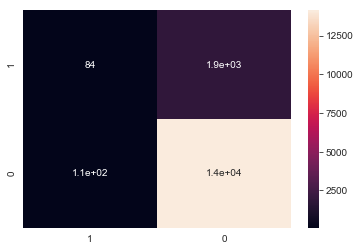

In [122]:
abt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, min_samples_split=15
                                                    , min_samples_leaf=5),algorithm="SAMME"
                                                    , n_estimators=maxscore[1], learning_rate=maxscore[2])
abt = abt.fit(X_train,Y_train)
y_probas_abt = abt.predict_proba(X_test)  
skplt.metrics.plot_roc(Y_test,y_probas_abt,title='Adaboost ROC',plot_macro=False,plot_micro=False,figsize=[6,6]);
plt.show()
y_hat = abt.predict(X_test)
con_matrix.con_matrix(Y_test,y_hat);
plt.show()

### KNN


100%|██████████████████████████████████████████| 11/11 [07:11<00:00, 39.69s/it]

48 0.8800914766054763


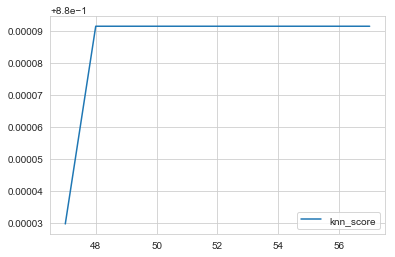

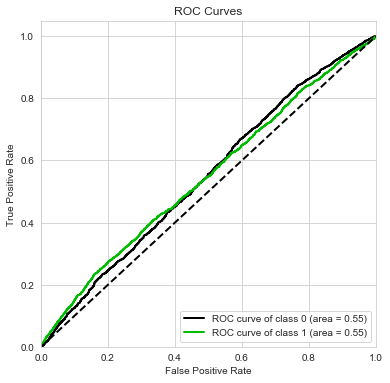

accuracy: 0.8800914766054763
precision: 0.46153846153846156
confusion matrix [[    6  1933]
 [    7 14233]]


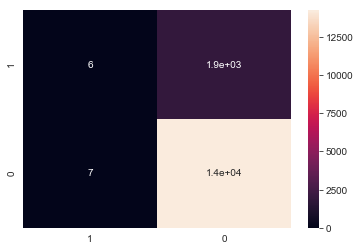

In [113]:
from sklearn.neighbors import KNeighborsClassifier as KNN
score = []
krange = range(40,58,1)
for i in tqdm(krange):
    knn = KNN(i,weights = 'distance').fit(X_train,Y_train)
    each_score = knn.score(X_test,Y_test)
    score.append(each_score)
knn_i = list(krange)[np.argmax(score)]
print(knn_i,np.max(score))

sns.set_style('whitegrid')
plt.plot(krange,score,label='knn_score');
plt.legend()

knn = KNN(knn_i,weights = 'distance').fit(X_train,Y_train)
y_probas_knn = knn.predict_proba(X_test)
skplt.metrics.plot_roc(Y_test,y_probas_knn,plot_macro=False,plot_micro=False,figsize=[6,6]);
plt.show()
y_hat = knn.predict(X_test)
con_matrix.con_matrix(Y_test,y_hat)
plt.show()

### 逻辑回归

In [253]:
# 逻辑回归
from sklearn.linear_model import LogisticRegression as LR

clf = LR(penalty='l2',solver = 'liblinear',C =0.3,max_iter=1000,class_weight='balanced')   
cvresult = CVS(clf,X_train,Y_train,cv=3).mean()
print(cvresult)

0.5581222776877678


### xgboost


100%|████████████████████████████████████████████| 9/9 [06:16<00:00, 44.87s/it]

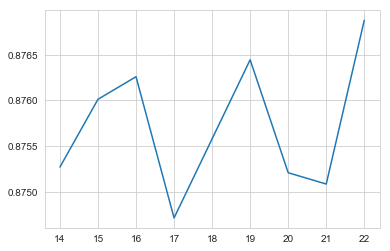

22 0.8768774337103653


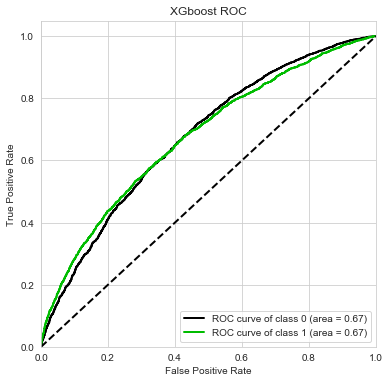

accuracy: 0.8768774337103653
precision: 0.4265927977839335
confusion matrix [[  154  1785]
 [  207 14033]]


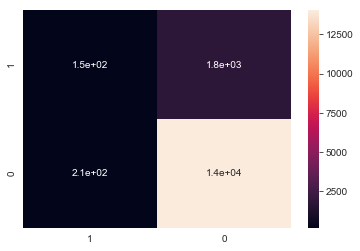

In [114]:
# XGBOOST    自我迭代，因此这里没有用训练集的准确度，来去找最优模型
from xgboost import XGBClassifier as XGBC
krange = range(14,23,1)
score = []
maxscore = 0
weight = Y_train.value_counts()[0]/Y_train.value_counts()[1]
for i in tqdm(krange):
    xgbc = XGBC(max_depth=i,n_jobs=-1,n_estimators=300,scale_pos_weight=weight)
    xgbc = xgbc.fit(X_train, Y_train)
    score_each = xgbc.score(X_test,Y_test)
    score.append(score_each)
    if score_each>maxscore:
        maxscore = score_each
        max_depth = i

sns.set_style('whitegrid')
plt.plot(krange,score);
plt.show()
print(max_depth,maxscore)

xgbc = XGBC(max_depth=max_depth,n_jobs=-1,n_estimators=300,scale_pos_weight=weight)
xgbc = xgbc.fit(X_train,Y_train)
y_probas_bdt = xgbc.predict_proba(X_test)  
skplt.metrics.plot_roc(Y_test,y_probas_bdt,title='XGboost ROC',plot_macro=False,plot_micro=False,figsize=[6,6]);
plt.show()
y_hat = xgbc.predict(X_test)
con_matrix.con_matrix(Y_test,y_hat);
plt.show()

### SVM

D:\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


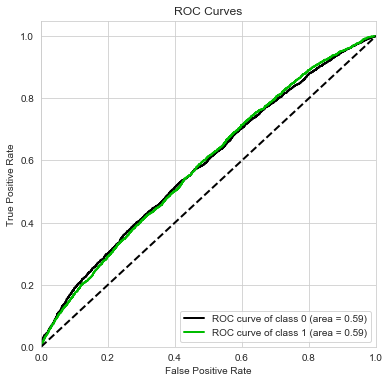

0.5234563322825886
accuracy: 0.5234563322825886
precision: 0.14389732197951377
confusion matrix [[1166  773]
 [6937 7303]]


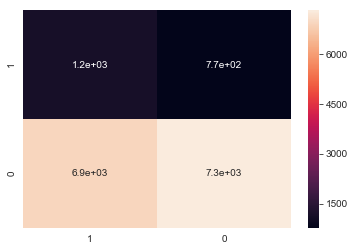

In [115]:
from sklearn.svm import SVC
clf= SVC(kernel = 'rbf',C=0.5,cache_size=5000,probability=True,class_weight="balanced").fit(X_train,Y_train)
score = clf.score(X_test,Y_test)

y_probas = clf.predict_proba(X_test)  
skplt.metrics.plot_roc(Y_test,y_probas,plot_macro=False,plot_micro=False,figsize=[6,6]);
plt.show();
print(score)
y_hat = clf.predict(X_test)
con_matrix.con_matrix(Y_test,y_hat);
plt.show()

## 使用模型进行预测

- 最终模型敲定为XGBOOST

In [124]:
user_info_test = pd.read_csv('./个人征信/user_info_test.txt',header=None)
user_info_test.columns = ['user_id','sex','occupation','education','marriage','residence']

In [125]:
bank_detail_test = pd.read_csv('./个人征信/bank_detail_test.txt',header=None)
bank_detail_test.columns = ['user_id','timestamp','trade_type','trade_amount','salary_label']

In [126]:
browse_history_test = pd.read_csv('./个人征信/browse_history_test.txt',header= None)
browse_history_test.columns = ['user_id','timestamp','behavior_data','behavior_num']

In [127]:
bill_detail_test = pd.read_csv('./个人征信/bill_detail_test.txt',header = None)
bill_detail_test.columns = ['user_id',                        # 用户ID
                           'timestamp',                      # 账单时间戳
                           'bank_id',                        # 银行ID
                           'L_BA',                           # 上期账单金额
                           'L_RA',                           # 上期还款金额
                           'credit_card_limit',              # 信用卡额度
                           'C_bill_balance',                 # 本期账单余额
                           'min_C_bill_R',                   # 本期账单最低还款额
                           'number_of_consumption',          # 消费笔数
                           'C_bill_amount',                  # 本期账单金额
                           'adjust_amount',                  # 调整金额
                           'compound_interest',              # 循环利息
                           'available_amount',               # 可用金额
                           'cash_advance_limit',             # 预借现金额度
                           'R_status',                       # 还款状态
                          ]

In [128]:
loan_time_test = pd.read_csv('./个人征信/loan_time_test.txt',header=None)
loan_time.columns=['user_id','timestamp']

In [129]:
usersID_test = pd.read_csv('./个人征信/usersID_test.txt',header =  None)
usersID_test.columns=['user_id']

In [130]:
import pre_data_trans
pred_data =pre_data_trans.data_translate(user_info_test,
                                         bank_detail_test,
                                         browse_history_test,
                                         bill_detail_test,
                                         model,
                                         MinMax_1st,
                                         MinMax_2nd)

D:\数据分析就业班\个人征信预测\pre_data_trans.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  bank_detail1.timestamp[bank_detail1['timestamp'] ==0]=np.nan
D:\数据分析就业班\个人征信预测\pre_data_trans.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  Y[Y.isnull()]= rfc.predict(X_test)


In [131]:
# 划分数据集合训练集
user_id = pred_data['user_id']
X= pred_data.iloc[:,1:]

In [135]:
# XGBOOST    自我迭代，因此这里没有用训练集的准确度，来去找最优模型
from xgboost import XGBClassifier as XGBC
maxscore = {}
maxscore['maxscore']=0
weight = Y_train.value_counts()[0]/Y_train.value_counts()[1]

In [137]:
# 对于best_max_depth 以及min_child_weight 进行调整
for i in tqdm(range(14,23,2)):
    for j in range(1,8,2):
        xgbc = XGBC(max_depth=i,min_child_weight =j,n_jobs=-1,n_estimators=300,scale_pos_weight=weight)
        xgbc = xgbc.fit(X_train, Y_train)
        score_each = xgbc.score(X_test,Y_test)
        if score_each>maxscore['maxscore']:
            maxscore['best_max_depth'] = i
            maxscore['min_child_weight'] = j
            maxscore['maxscore'] = score_each
# 对于gamma 值进行调整
for i in tqdm([i/10.0 for i in range(0,5)]):
    xgbc = XGBC(max_depth=maxscore['best_max_depth'],
                min_child_weight = maxscore['min_child_weight'],
                gamma = i,
                n_jobs=-1,
                n_estimators=300,
                scale_pos_weight=weight)
    xgbc = xgbc.fit(X_train, Y_train)
    score_each = xgbc.score(X_test,Y_test)
    if score_each>maxscore['maxscore']:
        maxscore['gamma'] = i
        maxscore['maxscore'] = score_each
    else:
        maxscore['gamma']=0



  0%|                                                    | 0/5 [00:00<?, ?it/s]

 20%|████████▌                                  | 1/5 [02:32<10:11, 152.81s/it]

 40%|█████████████████▏                         | 2/5 [05:20<07:51, 157.15s/it]

 60%|█████████████████████████▊                 | 3/5 [08:09<05:21, 160.84s/it]

 80%|██████████████████████████████████▍        | 4/5 [11:13<02:47, 167.82s/it]

100%|███████████████████████████████████████████| 5/5 [14:29<00:00, 176.12s/it]

  0%|                                                    | 0/5 [00:00<?, ?it/s]

 20%|████████▊                                   | 1/5 [00:50<03:20, 50.07s/it]

 40%|█████████████████▌                          | 2/5 [01:42<02:31, 50.66s/it]

 60%|██████████████████████████▍                 | 3/5 [02:32<01:41, 50.69s/it]

 80%|███████████████████████████████████▏        | 4/5 [03:24<00:50, 50.89s/it]

100%|████████████████████████████████████████████| 5/5 [04:15<00:00, 51.00s/it]

In [141]:
# 对于正则化项进行调参
for i in tqdm([1e-5, 1e-2, 0.1, 1, 100]):
    xgbc = XGBC(max_depth=maxscore['best_max_depth'],
                min_child_weight = maxscore['min_child_weight'],
                gamma = maxscore['gamma'],
                reg_alpha = i,
                n_jobs=-1,
                n_estimators=300,
                scale_pos_weight=weight)
    xgbc = xgbc.fit(X_train, Y_train)
    score_each = xgbc.score(X_test,Y_test)
    if score_each>maxscore['maxscore']:
        maxscore['reg_alpha'] = i
        maxscore['maxscore'] = score_each
    else:
        maxscore['reg_alpha']=0



  0%|                                                    | 0/5 [00:00<?, ?it/s]

 20%|████████▊                                   | 1/5 [00:51<03:26, 51.60s/it]

 40%|█████████████████▌                          | 2/5 [01:43<02:34, 51.61s/it]

 60%|██████████████████████████▍                 | 3/5 [02:33<01:42, 51.25s/it]

 80%|███████████████████████████████████▏        | 4/5 [03:21<00:50, 50.36s/it]

100%|████████████████████████████████████████████| 5/5 [03:49<00:00, 43.47s/it]

In [146]:
for i in tqdm([i / 10.0 for i in range(6,10)]):
    xgbc = XGBC(max_depth=maxscore['best_max_depth'],
                min_child_weight = maxscore['min_child_weight'],
                gamma = maxscore['gamma'],
                reg_alpha = maxscore['reg_alpha'],
                subsample = i,
                n_jobs=-1,
                n_estimators=300,
                scale_pos_weight=weight)
    xgbc = xgbc.fit(X_train, Y_train)
    score_each = xgbc.score(X_test,Y_test)
    if score_each>maxscore['maxscore']:
        maxscore['subsample'] = i
        maxscore['maxscore'] = score_each
    else:
        maxscore['subsample']=1




  0%|                                                    | 0/4 [00:00<?, ?it/s]


 25%|███████████                                 | 1/4 [00:45<02:17, 45.90s/it]


 50%|██████████████████████                      | 2/4 [01:32<01:32, 46.07s/it]


 75%|█████████████████████████████████           | 3/4 [02:19<00:46, 46.42s/it]


100%|████████████████████████████████████████████| 4/4 [03:15<00:00, 49.33s/it]

In [147]:
for i in tqdm([i / 10.0 for i in range(6,10)]):
    xgbc = XGBC(max_depth=maxscore['best_max_depth'],
                min_child_weight = maxscore['min_child_weight'],
                gamma = maxscore['gamma'],
                reg_alpha = maxscore['reg_alpha'],
                subsample = maxscore['subsample'],
                colsample_bytree = i,
                n_jobs=-1,
                n_estimators=300,
                scale_pos_weight=weight)
    xgbc = xgbc.fit(X_train, Y_train)
    score_each = xgbc.score(X_test,Y_test)
    if score_each>maxscore['maxscore']:
        maxscore['colsample_bytree'] = i
        maxscore['maxscore'] = score_each
    else:
        maxscore['colsample_bytree']=1




  0%|                                                    | 0/4 [00:00<?, ?it/s]


 25%|███████████                                 | 1/4 [00:35<01:47, 35.71s/it]


 50%|██████████████████████                      | 2/4 [01:15<01:13, 36.89s/it]


 75%|█████████████████████████████████           | 3/4 [01:59<00:39, 39.01s/it]


100%|████████████████████████████████████████████| 4/4 [02:48<00:00, 41.93s/it]

In [169]:
maxscore

{'maxscore': 0.8773719018480747,
 'best_max_depth': 22,
 'min_child_weight': 1,
 'gamma': 0,
 'reg_alpha': 0,
 'subsample': 1,
 'colsample_bytree': 1}

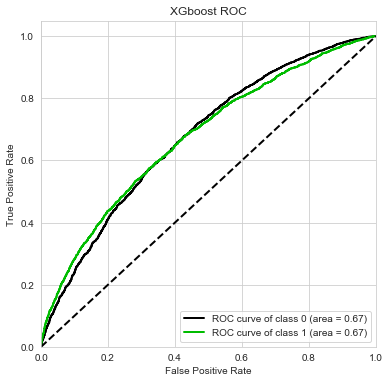

accuracy: 0.8768774337103653
precision: 0.4265927977839335
confusion matrix [[  154  1785]
 [  207 14033]]


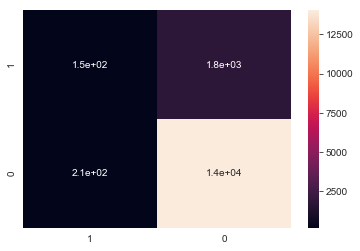

In [149]:
xgbc = XGBC(max_depth=maxscore['best_max_depth'],
            min_child_weight = maxscore['min_child_weight'],
            gamma = maxscore['gamma'],
            reg_alpha = maxscore['reg_alpha'],
            subsample = maxscore['subsample'],
            colsample_bytree = maxscore['colsample_bytree'],
            n_jobs=-1,
            n_estimators=300,
            scale_pos_weight=weight)
xgbc = xgbc.fit(X_train,Y_train)
y_probas_bdt = xgbc.predict_proba(X_test)  
skplt.metrics.plot_roc(Y_test,y_probas_bdt,title='XGboost ROC',plot_macro=False,plot_micro=False,figsize=[6,6]);
plt.show()
y_hat = xgbc.predict(X_test)
con_matrix.con_matrix(Y_test,y_hat);
plt.show()

In [151]:
pred_data['Y_predict'] = xgbc.predict(X)

In [165]:
pre_final = pred_data[['user_id','Y_predict']]

In [168]:
pre_final.Y_predict.value_counts()

0    13628
1      271
Name: Y_predict, dtype: int64